In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_gaussian_observation import ARGaussianObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from tqdm import tqdm_notebook as tqdm
import sys
import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from ssm.hmm import HMM as ssm_HMM

# Generate synthetic data

In [3]:
npr.seed(0)

K = 3
D = 2
T = 100

In [4]:
torch.manual_seed(0)
npr.seed(0)

As = [random_rotation(D) for _ in range(K)]
true_tran = LinearTransformation(K=K, D=D, lags=1, As=As, use_bias=True)
true_observation = ARGaussianObservation(K=K, D=D, M=0, lags=1, transformation=true_tran)
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

In [5]:
z, data = true_model.sample(T, return_np=True)

In [6]:
true_model.log_likelihood(data)

tensor(-652.9456, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

# check log prob computation is correct.
baseline: ssm package

In [7]:
baseline_hmm = ssm_HMM(K=K, D=D, observations='diagonal_ar')

In [8]:
log_p0 = torch.nn.LogSoftmax(dim=0)(true_model.pi0)

In [9]:
log_P = torch.nn.LogSoftmax(dim=1)(true_model.Pi)

In [10]:
baseline_hmm.init_state_distn.log_pi0 = log_p0.detach().numpy()

In [11]:
baseline_hmm.transitions.log_Ps = log_P.detach().numpy()

In [12]:
baseline_hmm.observations.mu_init = true_observation.mus_init.numpy()

In [13]:
baseline_hmm.observations.sigmasq_init = np.exp(true_observation.log_sigmas_init.numpy()) **2

In [14]:
baseline_hmm.observations.sigmasq = np.exp(true_observation.log_sigmas.detach().numpy()) ** 2

In [15]:
baseline_hmm.observations.As = np.transpose(true_tran.As.detach().numpy(), (0, 2, 1))

In [16]:
baseline_hmm.observations.bs = true_tran.bs.detach().numpy()

In [17]:
baseline_hmm.log_likelihood(data)

-652.9456397729836

# Define a model to fit the data

In [18]:
tran = LinearTransformation(K=K, D=D, lags=1, use_bias=True)
observation = ARGaussianObservation(K=K, D=D, M=0, lags=1, transformation=tran)
model = HMM(K=K, D=D, M=0, observation=observation)

# Model fitting

In [19]:
num_iters = 10000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

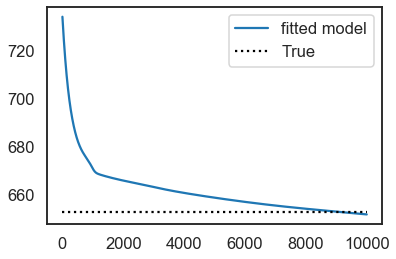

In [20]:
#true_loss = true_model.loss(data)
plt.plot(losses, label='fitted model')
plt.plot([0, num_iters], true_model.loss(data).detach().numpy() * np.ones(2), ':k', label="True")
plt.legend()
plt.show()

# Now, infer the latent states

In [21]:
infer_z = model.most_likely_states(data)

perm = find_permutation(z, infer_z, K1=K, K2=K)

model.permute(perm)
hmm_z = model.most_likely_states(data)

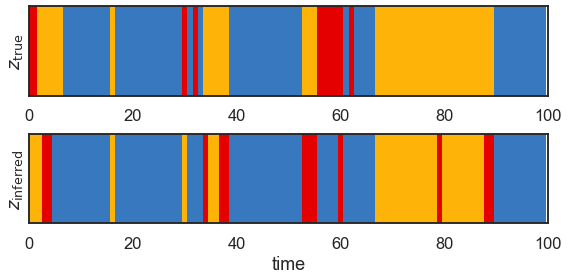

In [22]:
# Plot the true and inferred discrete states

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [23]:
torch.nn.Softmax(dim=1)(model.Pi)

tensor([[0.9032, 0.0471, 0.0497],
        [0.3503, 0.4456, 0.2041],
        [0.0801, 0.1267, 0.7932]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [24]:
torch.nn.Softmax(dim=1)(true_model.Pi)

tensor([[0.7910, 0.1048, 0.1042],
        [0.1043, 0.7904, 0.1053],
        [0.1066, 0.1037, 0.7897]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

# compare to baseline ssm_hmm

In [25]:
N_iters = 50

hmm = ssm_HMM(K, D, observations="diagonal_ar")

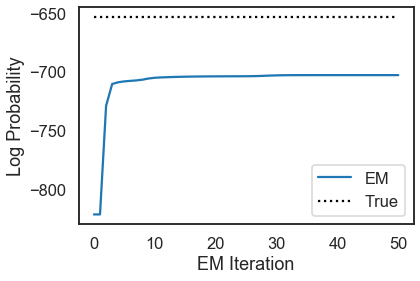

In [26]:
hmm_lls = hmm.fit(data, method="em", num_em_iters=N_iters)

plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_model.log_likelihood(data).detach().numpy() * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")

In [27]:
# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(data), K, K))

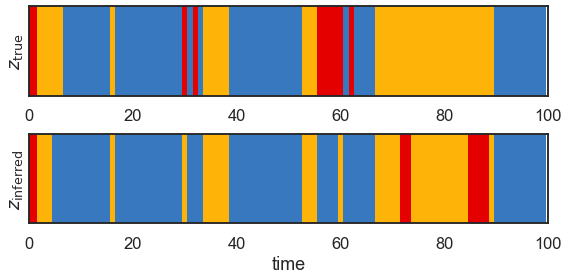

In [28]:
# Plot the true and inferred discrete states
ssm_hmm_z = hmm.most_likely_states(data)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(ssm_hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [29]:
hmm.transitions.transition_matrix

array([[9.10595399e-01, 1.67966148e-18, 8.94046009e-02],
       [6.48860947e-11, 5.63939442e-01, 4.36060558e-01],
       [2.09375221e-01, 8.34882955e-02, 7.07136483e-01]])

In [30]:
torch.nn.Softmax(dim=1)(true_model.Pi)

tensor([[0.7910, 0.1048, 0.1042],
        [0.1043, 0.7904, 0.1053],
        [0.1066, 0.1037, 0.7897]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

# Generate sample data from the fitted model

In [31]:
sample_z, sample_data = model.sample(T)

In [32]:
sample_data.shape

(100, 2)

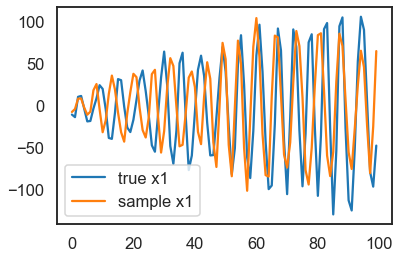

In [33]:
plt.plot(data[:,0], label='true x1')
plt.plot(sample_data[:,0], label='sample x1')
plt.legend()
plt.show()

# check prediction

In [34]:
x_predict_cond_z = k_step_prediction(model, z, data)

In [35]:
x_predict_cond_most_likely_z = k_step_prediction(model, hmm_z, data)

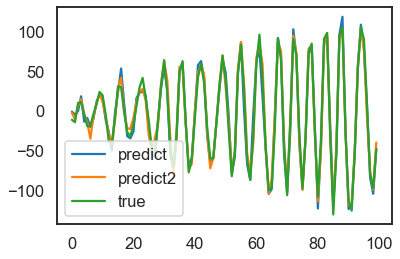

In [36]:
plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,0], label='predict2')
plt.plot(data[:,0], label='true')
plt.legend()

# check reconstructon

feed in the whole z-sequence and the first data point, then sample the observation

In [37]:
x_reconstruct = model.sample_condition_on_zs(z, data[0])

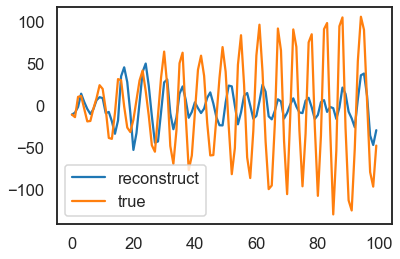

In [38]:
plt.plot(x_reconstruct[:,0], label='reconstruct')
plt.plot(data[:,0], label='true')
plt.legend()

In [39]:
x_reconstruct_2 = model.sample_condition_on_zs(hmm_z, data[0])

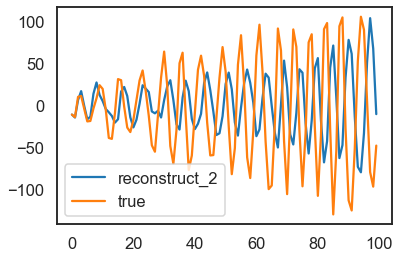

In [40]:
plt.plot(x_reconstruct_2[:,0], label='reconstruct_2')
plt.plot(data[:,0], label='true')
plt.legend()

# test lags

In [41]:
true_observation = ARGaussianObservation(K=K, D=D, M=0, lags=5, transformation='linear')
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

In [42]:
z, data = true_model.sample(T, return_np=True)

In [43]:
# fit to a model
observation = ARGaussianObservation(K=K, D=D, M=0, lags=5, transformation='linear')
model = HMM(K=K, D=D, M=0, observation=observation)

In [44]:
num_iters = 10000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

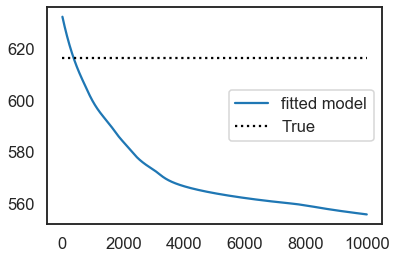

In [45]:
# plot loss
true_loss = true_model.loss(data)
plt.plot(losses, label='fitted model')
plt.plot([0, num_iters], true_model.loss(data).detach().numpy() * np.ones(2), ':k', label="True")
plt.legend()
plt.show()

In [46]:
# infer hidden states
infer_z = model.most_likely_states(data)

perm = find_permutation(z, infer_z, K1=K, K2=K)

model.permute(perm)
hmm_z = model.most_likely_states(data)

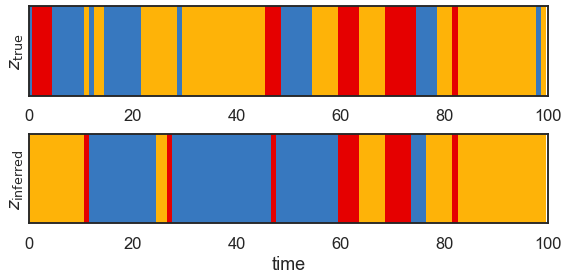

In [47]:
# Plot the true and inferred discrete states

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()